# **SENTIMENT ANALYSIS - SMARTPHONE REVIEW**

## **REQUIRED INSTALLATIONS**

In [7]:
!pip install autocorrect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **REQUIRED LIBRARIES**

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import time
import warnings
warnings.filterwarnings(action='ignore')

In [108]:
from bs4 import BeautifulSoup
import re
import nltk
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from autocorrect import Speller
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from wordcloud import WordCloud

In [10]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## **READING DATASET**

In [11]:
df = pd.read_csv('/content/Dataset.csv')

In [12]:
df.head()

,Unnamed: 0,asin,Brand,Item,name,rate,date,verified,title,body,helpfulVotes
0,0,B0000SX2UC,Nokia,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,Janet,NEUTRAL,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,1,B0000SX2UC,Nokia,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,Luke Wyatt,NEGATIVE,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,2,B0000SX2UC,Nokia,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,Brooke,POSITIVE,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,3,B0000SX2UC,Nokia,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,amy m. teague,NEUTRAL,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,4,B0000SX2UC,Nokia,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,tristazbimmer,POSITIVE,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0


In [13]:
df.shape

(67986, 11)

## **PRE-PROCESSING**

### **REMOVING UNWANTED COLUMNS**

In [14]:
df[['title', 'body', 'rate']].head()

,title,body,rate
0,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,NEUTRAL
1,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,NEGATIVE
2,Love This Phone,"This is a great, reliable phone. I also purcha...",POSITIVE
3,"Love the Phone, BUT...!","I love the phone and all, because I really did...",NEUTRAL
4,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,POSITIVE


In [15]:
# Combinging the title and body columns
df['body'] = df['title'] + ' ' + df['body']

In [16]:
# dropping all columns except body and rate
df1 = df.drop(['Unnamed: 0','asin','Item','Brand','name','date','title','verified','helpfulVotes'], axis=1)

In [17]:
df1.head()

,rate,body
0,NEUTRAL,"Def not best, but not worst I had the Samsung ..."
1,NEGATIVE,Text Messaging Doesn't Work Due to a software ...
2,POSITIVE,"Love This Phone This is a great, reliable phon..."
3,NEUTRAL,"Love the Phone, BUT...! I love the phone and a..."
4,POSITIVE,"Great phone service and options, lousy case! T..."


### **TREATING NULL & DUPLICATE VALUES**

In [18]:
df1.isna().sum()

rate     0
body    30
dtype: int64

In [19]:
df1 = df1.dropna(subset=['body'])

In [20]:
df1.isna().sum()

rate    0
body    0
dtype: int64

In [21]:
## Check duplicate
df1.duplicated().sum()

5675

In [22]:
# Dropping all duplicate valued rows
df1 = df1.drop_duplicates(ignore_index=True)

In [23]:
df1.shape

(62281, 2)

In [24]:
# Checking the distribution of TARGET column
df1['rate'].value_counts()

POSITIVE    42045
NEGATIVE    15727
NEUTRAL      4509
Name: rate, dtype: int64

### **DENOISE THE BODY**

In [25]:
# Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

In [26]:
# Applying denoise function on Body column
df1['body'] = df1['body'].apply(denoise_text)

In [27]:
df1.head()

,rate,body
0,NEUTRAL,"Def not best, but not worst I had the Samsung ..."
1,NEGATIVE,Text Messaging Doesn't Work Due to a software ...
2,POSITIVE,"Love This Phone This is a great, reliable phon..."
3,NEUTRAL,"Love the Phone, BUT...! I love the phone and a..."
4,POSITIVE,"Great phone service and options, lousy case! T..."


### **REMOVING SPECIAL CHARACTERS**

In [28]:
# Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "i am ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\^^", "", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    return text

In [29]:
# Applying special character removal function on body column
df1['body'] = df1['body'].apply(remove_special_characters)

In [30]:
df1.head()

,rate,body
0,NEUTRAL,Def not best but not worst I had the Samsung A...
1,NEGATIVE,Text Messaging Doesnt Work Due to a software i...
2,POSITIVE,Love This Phone This is a great reliable phone...
3,NEUTRAL,Love the Phone BUT I love the phone and all be...
4,POSITIVE,Great phone service and options lousy case The...


### **APPLY LEMMATIZER**

In [31]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [32]:
# Lematizing the text
def word_lemman(text):
    ln = WordNetLemmatizer()
    text= ' '.join([ln.lemmatize(word) for word in text.split()])
    return text

In [33]:
df1['body'] = df1['body'].apply(word_lemman)

In [34]:
# Stemming the text
def simple_stemmer(text):
    #ps = nltk.stem.LancasterStemmer()
    ps = SnowballStemmer(language='english')
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

In [35]:
#df1['body'] = df1['body'].apply(simple_stemmer)

In [36]:
df1.head()

,rate,body
0,NEUTRAL,Def not best but not worst I had the Samsung A...
1,NEGATIVE,Text Messaging Doesnt Work Due to a software i...
2,POSITIVE,Love This Phone This is a great reliable phone...
3,NEUTRAL,Love the Phone BUT I love the phone and all be...
4,POSITIVE,Great phone service and option lousy case The ...


### **VECTORIZATION**

In [37]:
# preprocess all the articles of the data set
token_body = df1.body.apply(lambda x: simple_preprocess(x))

In [38]:
token_body

0        [def, not, best, but, not, worst, had, the, sa...
1        [text, messaging, doesnt, work, due, to, softw...
2        [love, this, phone, this, is, great, reliable,...
3        [love, the, phone, but, love, the, phone, and,...
4        [great, phone, service, and, option, lousy, ca...
                               ...                        
62276    [nice, product, this, wa, gift, and, the, reci...
62277    [good, deal, for, your, money, my, year, old, ...
62278    [tmobile, lte, work, perfect, in, the, us, so,...
62279    [phone, is, like, new, product, look, and, wor...
62280    [outstanding, phone, for, the, price, love, th...
Name: body, Length: 62281, dtype: object

In [39]:
#df1['body1'] = token_body

In [40]:
df1.head()

,rate,body
0,NEUTRAL,Def not best but not worst I had the Samsung A...
1,NEGATIVE,Text Messaging Doesnt Work Due to a software i...
2,POSITIVE,Love This Phone This is a great reliable phone...
3,NEUTRAL,Love the Phone BUT I love the phone and all be...
4,POSITIVE,Great phone service and option lousy case The ...


### **SPELLING CORRECTION**

In [41]:
spell = Speller(lang='en')

In [42]:
def correct_spelling(tokens):
    #sentence_corrected = ' '.join([spell(word) for word in tokens])
    sentence_corrected = ' '.join([spell(word) for word in tokens.split()])
     #text= ' '.join([ps.stem(word) for word in text.split()])
    return sentence_corrected

In [43]:
#df1['body'] = df1['body'].apply(correct_spelling)

In [44]:
df1.head()

,rate,body
0,NEUTRAL,Def not best but not worst I had the Samsung A...
1,NEGATIVE,Text Messaging Doesnt Work Due to a software i...
2,POSITIVE,Love This Phone This is a great reliable phone...
3,NEUTRAL,Love the Phone BUT I love the phone and all be...
4,POSITIVE,Great phone service and option lousy case The ...


### **STOP WORDS REMOVAL**

In [45]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [46]:
stop_words = stopwords.words('english')

In [47]:
# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
df1['body'] = df1['body'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [48]:
df1.head()

,rate,body
0,NEUTRAL,Def best worst I Samsung A600 awhile absolute ...
1,NEGATIVE,Text Messaging Doesnt Work Due software issue ...
2,POSITIVE,Love This Phone This great reliable phone I al...
3,NEUTRAL,Love Phone BUT I love phone I really need one ...
4,POSITIVE,Great phone service option lousy case The phon...


### **WORDCLOUD**

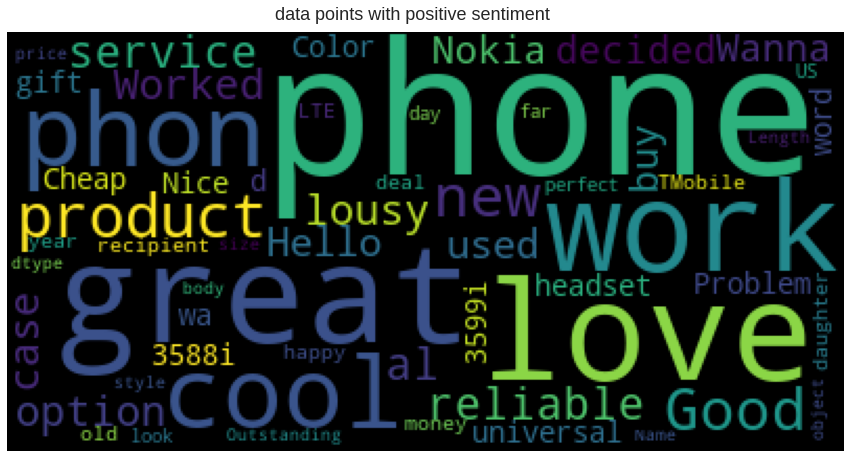

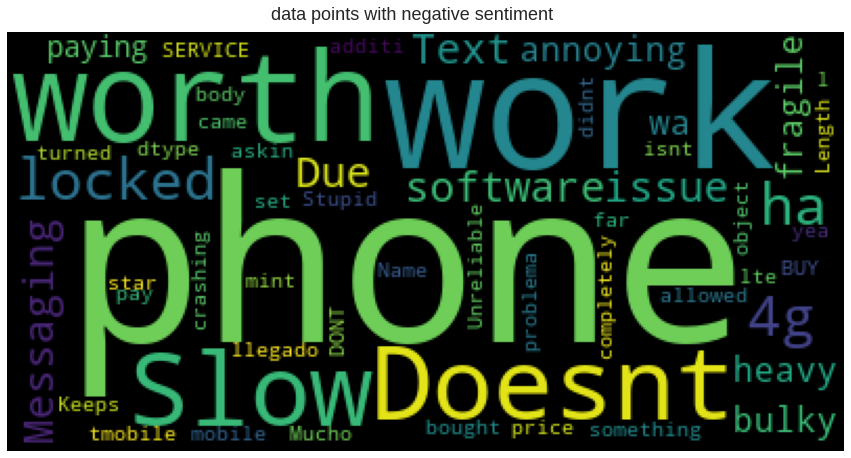

In [109]:
# plot word cloud function

def plot_wordcloud(sentences, title):
    # create word cloud
    wordcloud = WordCloud(background_color='black',
                          max_words=200).generate(str(sentences))
    # plt params
    fig = plt.figure(figsize=[15,15])
    plt.axis('off')
    plt.suptitle(title, fontsize=18)
    plt.subplots_adjust(top=1.4)
    plt.imshow(wordcloud)
    plt.show()
    
    return
    

# plot word cloud for training data with positive examples
plot_wordcloud(df1[df1['rate'] == 'POSITIVE']['body'], 'data points with positive sentiment')

# plot word cloud for training data with negative examples
plot_wordcloud(df1[df1['rate'] == 'NEGATIVE']['body'], 'data points with negative sentiment')

### **TFIdf1 VECTORIZATION**

In [49]:
vect = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS, ngram_range=(1,2), max_features=400).fit(df1.body)
vect

TfidfVectorizer(max_features=400, ngram_range=(1, 2),
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}))

In [50]:
X = vect.transform(df1.body).toarray()

In [51]:
# set the max columns to none
pd.set_option('display.max_columns', None)

In [52]:
X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.12849747],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.17245012],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [53]:
y = df1['rate'].map({'NEGATIVE':0, 'NEUTRAL':1, 'POSITIVE':2})

In [54]:
y

0        1
1        0
2        2
3        1
4        2
        ..
62276    2
62277    2
62278    2
62279    2
62280    2
Name: rate, Length: 62281, dtype: int64

## **Train-Test Splitting**

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [56]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((49824, 400), (12457, 400), (49824,), (12457,))

## **MODEL CREATION**

### **LOGISTIC REGRESSION**

In [151]:
lr = LogisticRegression(solver='saga', penalty='l2', max_iter=200)

start = time.process_time()
lr.fit(X_train, y_train)
elapsed1 = (time.process_time() - start)

In [152]:
y_pred1 = lr.predict(X_test)

print(classification_report(y_pred1, y_test, target_names=['NEGATIVE', 'NEUTRAL', 'POSITIVE']))
print('Confusion Matrix :', confusion_matrix(y_pred1, y_test), sep='\n')

              precision    recall  f1-score   support

    NEGATIVE       0.78      0.76      0.77      3222
     NEUTRAL       0.03      0.38      0.06        78
    POSITIVE       0.95      0.87      0.91      9157

    accuracy                           0.84     12457
   macro avg       0.59      0.67      0.58     12457
weighted avg       0.90      0.84      0.87     12457

Confusion Matrix :
[[2447  350  425]
 [  22   30   26]
 [ 677  522 7958]]


In [153]:
result1 = {'model':'Logistic Regression',
           'accuracy':accuracy_score(y_pred1, y_test),
           'precision_score':precision_score(y_pred1, y_test,average='weighted'),
           'recall_score':recall_score(y_pred1,y_test, average='weighted'),
           'f1_score':f1_score(y_pred1, y_test,average='weighted'),
           'confusion_matrix':confusion_matrix(y_pred1, y_test),
           'training_time':elapsed1}
result1

{'model': 'Logistic Regression',
 'accuracy': 0.8376816247892751,
 'precision_score': 0.8970531056568022,
 'recall_score': 0.8376816247892751,
 'f1_score': 0.8652042458420132,
 'confusion_matrix': array([[2447,  350,  425],
        [  22,   30,   26],
        [ 677,  522, 7958]]),
 'training_time': 12.683917481000208}

### **RANDOM FOREST**

In [130]:
rf = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='sqrt', min_samples_leaf=2, min_samples_split=10)

start = time.process_time()
rf.fit(X_train, y_train)
elapsed2 = (time.process_time() - start)

In [131]:
y_pred2 = rf.predict(X_test)

print(classification_report(y_pred2, y_test, target_names=['NEGATIVE', 'NEUTRAL', 'POSITIVE']))
print('Confusion Matrix :', confusion_matrix(y_pred2, y_test), sep='\n')

              precision    recall  f1-score   support

    NEGATIVE       0.74      0.77      0.76      3041
     NEUTRAL       0.01      0.40      0.01        15
    POSITIVE       0.95      0.85      0.90      9401

    accuracy                           0.83     12457
   macro avg       0.57      0.67      0.56     12457
weighted avg       0.90      0.83      0.86     12457

Confusion Matrix :
[[2336  308  397]
 [   5    6    4]
 [ 805  588 8008]]


In [132]:
result2 = {'model':'Random Forest',
           'accuracy':accuracy_score(y_pred2, y_test),
           'precision_score':precision_score(y_pred2, y_test,average='weighted'),
           'recall_score':recall_score(y_pred2, y_test, average='weighted'),
           'f1_score':f1_score(y_pred2, y_test, average='weighted'),
           'confusion_matrix':confusion_matrix(y_pred2, y_test),
           'training_time':elapsed2}
result2

{'model': 'Random Forest',
 'accuracy': 0.830858152043028,
 'precision_score': 0.8999621579491126,
 'recall_score': 0.830858152043028,
 'f1_score': 0.8630159615277659,
 'confusion_matrix': array([[2336,  308,  397],
        [   5,    6,    4],
        [ 805,  588, 8008]]),
 'training_time': 40.28079655600004}

### **SUPPORT VECTOR MACHINE**

In [64]:
svm_model = svm.SVC(kernel='linear', C = 0.01)

start = time.process_time()
svm_model.fit(X_train, y_train)
elapsed3 = (time.process_time() - start)

In [65]:
y_pred3 = svm_model.predict(X_test)

print(classification_report(y_pred3, y_test, target_names=['NEGATIVE', 'NEUTRAL', 'POSITIVE']))
print('Confusion Matrix :', confusion_matrix(y_pred3, y_test), sep='\n')

              precision    recall  f1-score   support

    NEGATIVE       0.63      0.83      0.71      2373
     NEUTRAL       0.00      0.00      0.00         0
    POSITIVE       0.97      0.81      0.89     10084

    accuracy                           0.82     12457
   macro avg       0.53      0.55      0.53     12457
weighted avg       0.91      0.82      0.85     12457

Confusion Matrix :
[[1972  190  211]
 [   0    0    0]
 [1174  712 8198]]


In [66]:
result3 = {'model':'Support Vector Machine',
           'accuracy':accuracy_score(y_pred3, y_test),
           'precision_score':precision_score(y_pred3, y_test,average='weighted'),
           'recall_score':recall_score(y_pred3, y_test, average='weighted'),
           'f1_score':f1_score(y_pred3, y_test, average='weighted'),
           'confusion_matrix':confusion_matrix(y_pred3, y_test),
           'training_time':elapsed3}
result3

{'model': 'Support Vector Machine',
 'accuracy': 0.8164084450509753,
 'precision_score': 0.9086002087901521,
 'recall_score': 0.8164084450509753,
 'f1_score': 0.8538436881870525,
 'confusion_matrix': array([[1972,  190,  211],
        [   0,    0,    0],
        [1174,  712, 8198]]),
 'training_time': 621.022588016}

### **ADABOOST CLASSIFIER**

In [67]:
adaboost = AdaBoostClassifier(n_estimators=50, learning_rate=1)

start = time.process_time()
adamodel = adaboost.fit(X_train, y_train)
elapsed4 = (time.process_time() - start)

In [68]:
y_pred4 = adaboost.predict(X_test)

print(classification_report(y_pred4, y_test, target_names=['NEGATIVE', 'NEUTRAL', 'POSITIVE']))
print('Confusion Matrix :', confusion_matrix(y_pred4, y_test), sep='\n')

              precision    recall  f1-score   support

    NEGATIVE       0.72      0.71      0.71      3157
     NEUTRAL       0.01      0.47      0.02        17
    POSITIVE       0.93      0.84      0.89      9283

    accuracy                           0.81     12457
   macro avg       0.55      0.68      0.54     12457
weighted avg       0.88      0.81      0.84     12457

Confusion Matrix :
[[2253  333  571]
 [   4    8    5]
 [ 889  561 7833]]


In [69]:
result4 = {'model':'AdaBoost',
           'accuracy':accuracy_score(y_pred4, y_test),
           'precision_score':precision_score(y_pred4, y_test,average='weighted'),
           'recall_score':recall_score(y_pred4, y_test, average='weighted'),
           'f1_score':f1_score(y_pred4, y_test, average='weighted'),
           'confusion_matrix':confusion_matrix(y_pred4, y_test),
           'training_time':elapsed4}
result4

{'model': 'AdaBoost',
 'accuracy': 0.8103074576543309,
 'precision_score': 0.8756651772801723,
 'recall_score': 0.8103074576543309,
 'f1_score': 0.8410680613906373,
 'confusion_matrix': array([[2253,  333,  571],
        [   4,    8,    5],
        [ 889,  561, 7833]]),
 'training_time': 23.60962651}

### **NAIVE BAYES**

In [70]:
nb = MultinomialNB()

start = time.process_time()
nb.fit(X_train, y_train)
elapsed5 = (time.process_time() - start)

In [71]:
y_pred5 = nb.predict(X_test)

print(classification_report(y_pred5, y_test, target_names=['NEGATIVE', 'NEUTRAL', 'POSITIVE']))
print('Confusion Matrix :', confusion_matrix(y_pred5, y_test), sep='\n')

              precision    recall  f1-score   support

    NEGATIVE       0.65      0.80      0.72      2565
     NEUTRAL       0.00      0.33      0.00         3
    POSITIVE       0.97      0.82      0.89      9889

    accuracy                           0.82     12457
   macro avg       0.54      0.65      0.54     12457
weighted avg       0.90      0.82      0.85     12457

Confusion Matrix :
[[2044  244  277]
 [   0    1    2]
 [1102  657 8130]]


In [72]:
result5 = {'model':'Naive Bayes',
           'accuracy':accuracy_score(y_pred5, y_test),
           'precision_score':precision_score(y_pred5, y_test,average='weighted'),
           'recall_score':recall_score(y_pred5, y_test, average='weighted'),
           'f1_score':f1_score(y_pred5, y_test, average='weighted'),
           'confusion_matrix':confusion_matrix(y_pred5, y_test),
           'training_time':elapsed5}
result5

{'model': 'Naive Bayes',
 'accuracy': 0.8168098258007546,
 'precision_score': 0.9012936506497731,
 'recall_score': 0.8168098258007546,
 'f1_score': 0.8528251927310282,
 'confusion_matrix': array([[2044,  244,  277],
        [   0,    1,    2],
        [1102,  657, 8130]]),
 'training_time': 0.11340269300012551}

### **K-NEAREST NEIGHBORS CLASSIFIER**

In [73]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance', algorithm='brute', leaf_size=120, n_jobs=-1)

start = time.process_time()
knn.fit(X_train, y_train)
elapsed6 = (time.process_time() - start)

In [74]:
y_pred6 = knn.predict(X_test)

print(classification_report(y_pred6, y_test, target_names=['NEGATIVE', 'NEUTRAL', 'POSITIVE']))
print('Confusion Matrix :', confusion_matrix(y_pred6, y_test), sep='\n')

              precision    recall  f1-score   support

    NEGATIVE       0.52      0.65      0.58      2500
     NEUTRAL       0.07      0.18      0.10       348
    POSITIVE       0.91      0.80      0.85      9609

    accuracy                           0.75     12457
   macro avg       0.50      0.54      0.51     12457
weighted avg       0.81      0.75      0.78     12457

Confusion Matrix :
[[1635  272  593]
 [ 142   62  144]
 [1369  568 7672]]


In [75]:
result6 = {'model':'KNN',
           'accuracy':accuracy_score(y_pred6, y_test),
           'precision_score':precision_score(y_pred6, y_test,average='weighted'),
           'recall_score':recall_score(y_pred6, y_test, average='weighted'),
           'f1_score':f1_score(y_pred6, y_test, average='weighted'),
           'confusion_matrix':confusion_matrix(y_pred6, y_test),
           'training_time':elapsed6}
result6

{'model': 'KNN',
 'accuracy': 0.7521072489363411,
 'precision_score': 0.8099876424011606,
 'recall_score': 0.7521072489363411,
 'f1_score': 0.775901504969599,
 'confusion_matrix': array([[1635,  272,  593],
        [ 142,   62,  144],
        [1369,  568, 7672]]),
 'training_time': 0.017773147999832872}

## **MODEL COMPARISON**

In [154]:
model_result = pd.DataFrame(columns=['model', 'accuracy', 'precision_score', 'recall_score', 'f1_score', 'confusion_matrix', 'training_time'])
model_result = model_result.append(result1, ignore_index=True)
model_result = model_result.append(result2, ignore_index=True)
model_result = model_result.append(result3, ignore_index=True)
model_result = model_result.append(result4, ignore_index=True)
model_result = model_result.append(result5, ignore_index=True)
model_result = model_result.append(result6, ignore_index=True)

model_result

,model,accuracy,precision_score,recall_score,f1_score,confusion_matrix,training_time
0,Logistic Regression,0.837682,0.897053,0.837682,0.865204,"[[2447, 350, 425], [22, 30, 26], [677, 522, 79...",12.683917
1,Random Forest,0.830858,0.899962,0.830858,0.863016,"[[2336, 308, 397], [5, 6, 4], [805, 588, 8008]]",40.280797
2,Support Vector Machine,0.816408,0.908600,0.816408,0.853844,"[[1972, 190, 211], [0, 0, 0], [1174, 712, 8198]]",621.022588
3,AdaBoost,0.810307,0.875665,0.810307,0.841068,"[[2253, 333, 571], [4, 8, 5], [889, 561, 7833]]",23.609627
4,Naive Bayes,0.816810,0.901294,0.816810,0.852825,"[[2044, 244, 277], [0, 1, 2], [1102, 657, 8130]]",0.113403
5,KNN,0.752107,0.809988,0.752107,0.775902,"[[1635, 272, 593], [142, 62, 144], [1369, 568,...",0.017773


In [77]:
plt.style.use('seaborn')
colors = sns.color_palette('pastel')

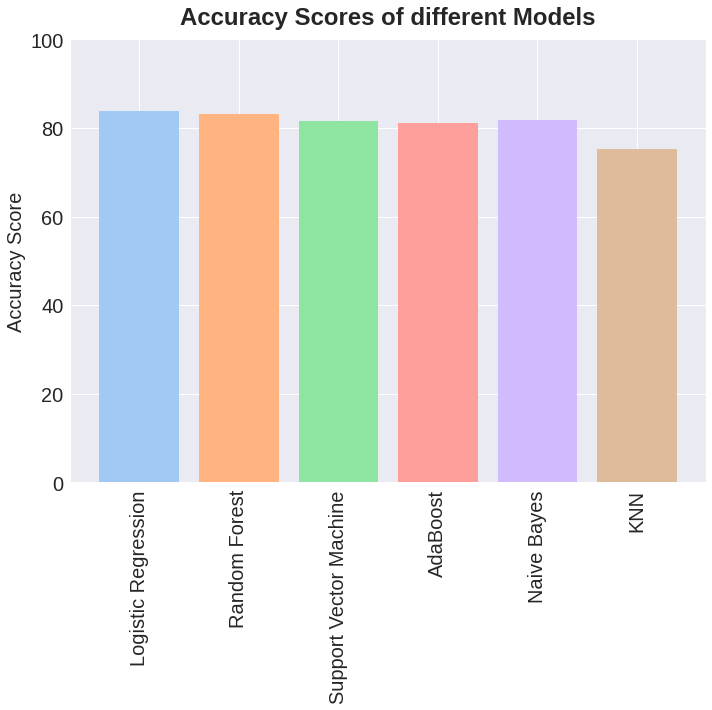

In [155]:
# Accuracy Score

x_values = model_result['model']
y_values = model_result['accuracy'] * 100

plt.figure(figsize=(10, 10))
plt.bar(x_values, y_values, color=colors)
plt.title('Accuracy Scores of different Models', fontsize=24, fontweight='bold', y=1.02)
plt.xticks(fontsize=20, rotation=90, fontweight=500)
plt.yticks(fontsize=20)
plt.ylabel('Accuracy Score', fontsize=20);
plt.ylim(bottom=0, top=100)

plt.tight_layout()
plt.savefig('model_comparison_accuracy_score.jpg', dpi=300)
plt.show()

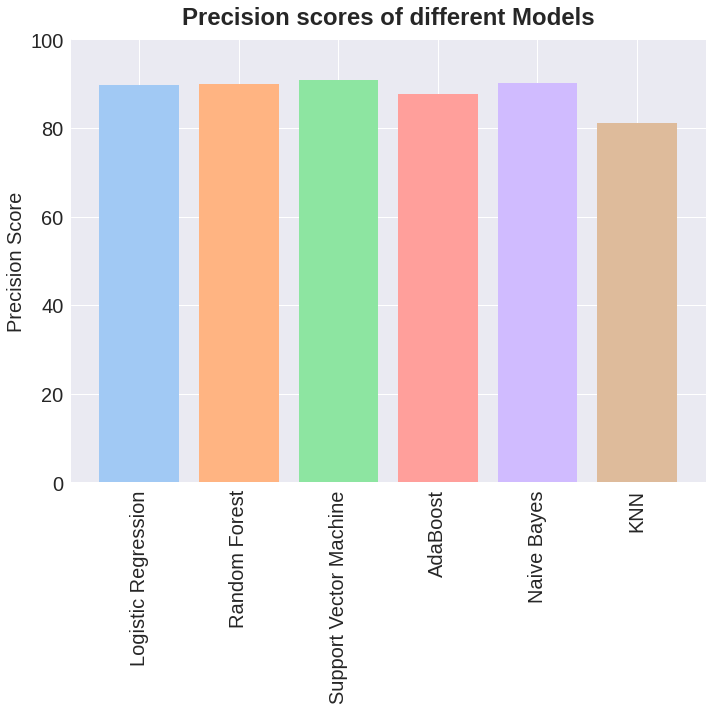

In [156]:
# Precision Score

x_values = model_result['model']
y_values = model_result['precision_score'] * 100

plt.figure(figsize=(10, 10))
plt.bar(x_values, y_values, color=colors)
plt.title('Precision scores of different Models', fontsize=24, fontweight='bold', y=1.02)
plt.xticks(fontsize=20, rotation=90, fontweight=500)
plt.yticks(fontsize=20)
plt.ylabel('Precision Score', fontsize=20);
plt.ylim(bottom=0, top=100)

plt.tight_layout()
plt.savefig('model_comparison_precision_score.jpg', dpi=300)
plt.show()

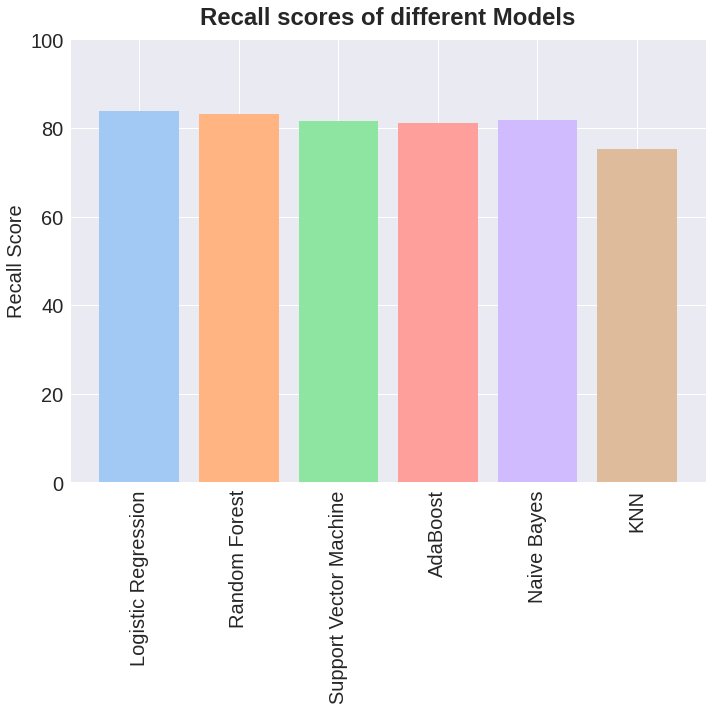

In [157]:
# Recall Score

x_values = model_result['model']
y_values = model_result['recall_score'] * 100

plt.figure(figsize=(10, 10))
plt.bar(x_values, y_values, color=colors)
plt.title('Recall scores of different Models', fontsize=24, fontweight='bold', y=1.02)
plt.xticks(fontsize=20, rotation=90, fontweight=500)
plt.yticks(fontsize=20)
plt.ylabel('Recall Score', fontsize=20);
plt.ylim(bottom=0, top=100)
plt.tight_layout()

plt.savefig('model_comparison_recall_score.jpg', dpi=300)
plt.show()

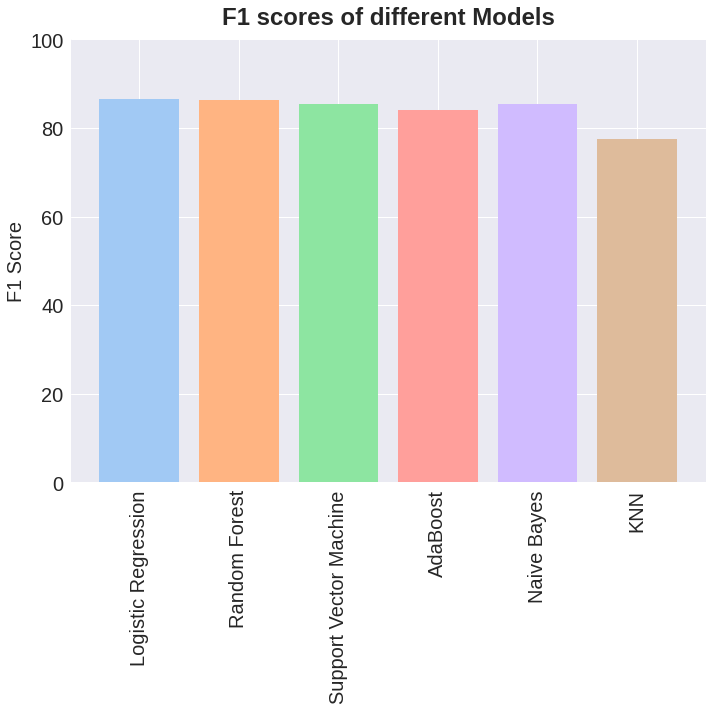

In [158]:
# F1 Score

x_values = model_result['model']
y_values = model_result['f1_score'] * 100

plt.figure(figsize=(10, 10))
plt.bar(x_values, y_values, color=colors)
plt.title('F1 scores of different Models', fontsize=24, fontweight='bold', y=1.02)
plt.xticks(fontsize=20, rotation=90, fontweight=500)
plt.yticks(fontsize=20)
plt.ylabel('F1 Score', fontsize=20);
plt.ylim(bottom=0, top=100)
plt.tight_layout()

plt.savefig('model_comparison_f1_score.jpg', dpi=300)
plt.show()

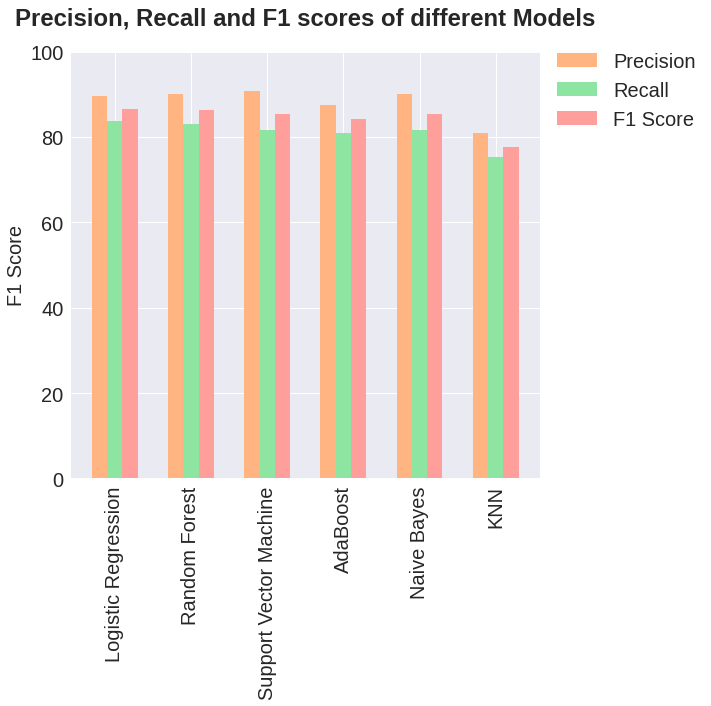

In [159]:
# Precision, Recall and F1 Scores

x_values = model_result['model']
x1 = np.arange(6)
y1 = model_result['precision_score'] * 100
y2 = model_result['recall_score'] * 100
y3 = model_result['f1_score'] * 100

plt.figure(figsize=(10, 10))
plt.bar(x1-0.2, y1, width=0.20, label='Precision', color=colors[1])
plt.bar(x1, y2, width=0.20, label='Recall', color=colors[2])
plt.bar(x1+0.2, y3, width=0.20, label='F1 Score', color=colors[3])
plt.title('Precision, Recall and F1 scores of different Models', fontsize=24, fontweight='bold', y=1.05)
plt.xticks(x1, x_values, fontsize=20, rotation=90, fontweight=500)
plt.yticks(fontsize=20)
plt.ylabel('F1 Score', fontsize=20);
plt.ylim(bottom=0, top=100)
plt.legend(loc=(1.02,0.8), borderaxespad=0, fontsize = 20)
plt.tight_layout()

plt.savefig('model_comparison_precision_recall_f1_score.jpg', dpi=300)
plt.show()

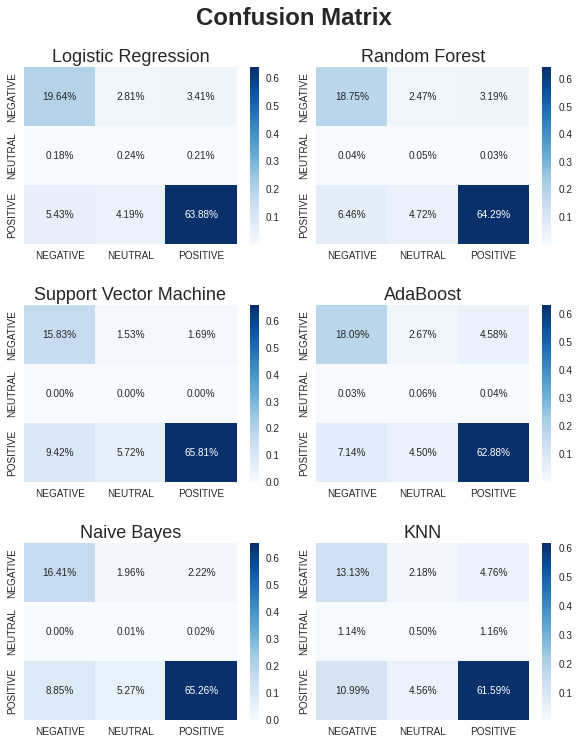

In [160]:
labels = ['NEGATIVE','NEUTRAL','POSITIVE']

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))
plt.subplots_adjust(hspace=0.35, wspace=0.1)
fig.suptitle("Confusion Matrix", fontsize=24, fontweight='bold', y=0.95)

for index in range(6):
    plt.subplot(3, 2, 1 + index )
    cf_matrix = model_result['confusion_matrix'][index]
    sns.heatmap(cf_matrix/np.sum(cf_matrix), fmt='.2%', annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(model_result['model'][index], fontsize=18, fontweight=500)
plt.savefig('model_comparison_confusion_matrix.jpg', dpi=300)
plt.show()

## **SELECTED MODEL PREDICTION**

In [175]:
test=pd.read_csv('/content/collected_review.csv')
test.dropna(inplace=True)
test=test.drop('Unnamed: 0',axis=1)

For testing purpose we have collected the data via web scrapping .: https://colab.research.google.com/drive/1IytJe9wmTPbZ9VRTguktJYu_yl4suO73?usp=sharing

In [176]:
vector = vect.transform(test['Review'])
print("Encoded Document is:")
print(vector.toarray())

Encoded Document is:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [182]:
test['Result']=rf.predict(vector)

In [183]:
test['Results']=test['Result'].map({0: 'Negative',1 : 'Positive', 2:'Nuetral'})

Final Result **Verification**

In [184]:
test

,Review,Result,Results
0,One of the best mobile it has a long lasting b...,2,Nuetral
1,Value for money,2,Nuetral
2,"I loved this phone, so good.",2,Nuetral
3,Good in this range,2,Nuetral
4,So the phone is good. At the time of booking t...,0,Negative
5,Good,2,Nuetral
6,Good overall at the price.,2,Nuetral
7,I bought this phone for my father and he like ...,2,Nuetral
8,"Average phone, battery drain issues, bad speak...",0,Negative
9,Like,2,Nuetral


Percentage **Evaluation**

In [185]:
print("Percentage Of Positive Reviews",100 * len(test[test.Results=='Positive'])/len(test.Results))
print("Percentage Of Negative Reviews",100 *len(test[test.Results=='Negative'])/len(test.Results))
print("Percentage Of Nuetral Reviews" , 100 *len(test[test.Results=='Nuetral'])/len(test.Results))

Percentage Of Positive Reviews 0.0
Percentage Of Negative Reviews 20.0
Percentage Of Nuetral Reviews 80.0


**Final Result**

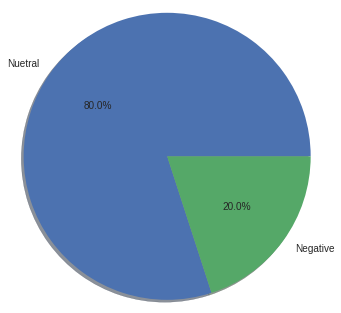

In [186]:
plt.pie(test.Result.value_counts().values[0:2],labels=test.Results.value_counts().index[0:2],autopct='%1.1f%%', shadow=True, radius=1.2)
plt.show()